## Convocatoria 1 - Proyecto 1

#### 0) Cargar una de las imágenes histológicas

(1024, 1024, 3)


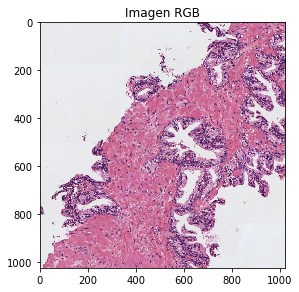

In [1]:
import matplotlib.pyplot as plt
from skimage import io
from skimage import morphology
import cv2
import numpy as np
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
img_rgb = io.imread("images/histo_1.jpg")

# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
img_rgb=img_rgb/255

# Visualizar la imagen
print(img_rgb.shape) #afirmamos que la imagen tiene 3 canales
io.imshow(img_rgb)
plt.title('Imagen RGB')
plt.show()




#### 1) Realizar una transformación de color para convertir la imagen al espacio de color CMYK

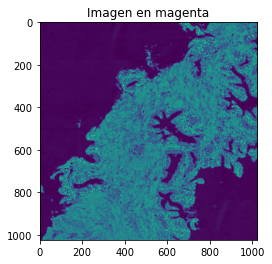

In [2]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)

with np.errstate(invalid='ignore', divide='ignore'):
    K = 1 - np.max(img_rgb, axis=2)
    C = (1-img_rgb[...,0] - K)/(1-K)
    M = (1-img_rgb[...,1] - K)/(1-K)
    Y = (1-img_rgb[...,2] - K)/(1-K)

CMYK = (np.dstack((C,M,Y,K)))
C,M,Y,K = cv2.split(CMYK)

# Visualizar la imagen del canal magenta
plt.imshow(M)
plt.title('Imagen en magenta')
plt.show()



#### 2) Umbralizar la imagen para separar los píxeles del fondo de la región tisular

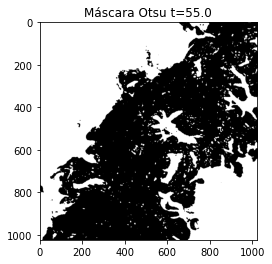

In [3]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".

#desnormalizamos la imagen porque el filtro de gauss sólo acepta valores comprendido 
img_magenta=M*255
#aplicamos el filtro gaussiano de tamaño 5x5
img_gaus = cv2.GaussianBlur(img_magenta, (5,5), 0) 
#utilizamos el metodo Otsu
t, mask = cv2.threshold(img_gaus.astype('uint8'),0,255,cv2.THRESH_OTSU) 
mask_invertida=np.invert(mask) #os píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0

# Visualizar la máscara resultante
plt.imshow(mask_invertida, cmap='gray')
plt.title('Máscara Otsu t=' + str(t))
plt.show()





#### 3) Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

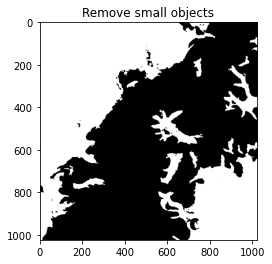

In [4]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizaer la máscara resultante
image_array=np.array(mask_invertida,bool)
img_elimina=morphology.remove_small_objects(image_array,min_size=300)#se sube el tamaño del area para discrimnar ciertos puntos no deeados
plt.imshow(img_elimina,cmap='gray')
plt.title('Remove small objects')
plt.show()



#### 4) Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

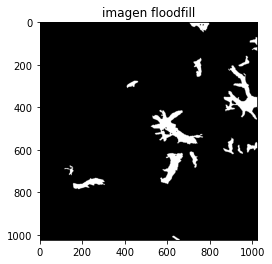

In [5]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
# Visualimask = img.copy()

mask_4 = img_elimina.astype('uint8').copy()

# Definir una imagen negra de referencia
h, w = img_elimina.shape
ref = np.zeros((h+2, w+2), np.uint8)

# Fijar la semilla. En este caso en la esquina superior izquierda (posición 0,0) para rellenar a partir de ahí
cv2.floodFill(mask_4, ref, (0,0), 0); # Como nos interesa rellenar de negro, utilizamos el 0 en la última posición
cv2.floodFill(mask_4, ref, (1000,1000), 0); # Como nos interesa rellenar de negro, utilizamos el 0 en la última posición
plt.imshow(mask_4,cmap='gray')
plt.title('imagen floodfill')
plt.show()


#### 5) Rellenar los objetos de los lúmenes

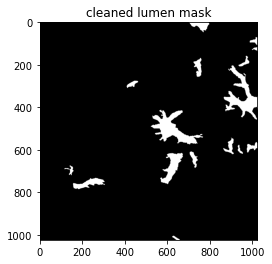

In [7]:
# Rellenar los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# Visualizar la máscara resultante
from scipy.ndimage.morphology import binary_fill_holes as bfh
bordes = mask_4.copy()
filled_bordes = bfh(bordes)

plt.imshow(filled_bordes.astype('uint8'), cmap='gray')
plt.title('cleaned lumen mask')
plt.show()


#### 6) Detectar y dibujar los contornos de los lúmenes sobre la imagen original

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


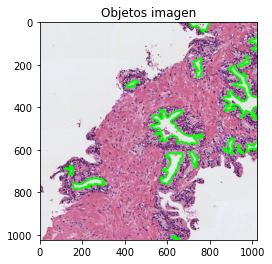

In [8]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles. 
# Visualizar la imagen superpuesta

from skimage.measure import label
from skimage.measure import regionprops
from skimage.morphology import convex_hull_image
lab, num = label(filled_bordes, return_num=True)
imagen=img_rgb.copy()
for i in range(1, num+1):
    objeto=lab==i
    objeto=objeto.astype('uint8')
    conts,_ = cv2.findContours(objeto, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    imagen = cv2.drawContours(imagen, conts, -1, (0,255,0), 8)

plt.imshow(imagen,cmap='gray')
plt.title('Objetos imagen')
plt.show()



#### 7) Identificar y cropear el lumen más grande

número de objetos:  16
posibles valores de intensidad:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
0        1    2    3    4     5      6    7      8     9    10    11    12    13    14    15    16
----  ----  ---  ---  ---  ----  -----  ---  -----  ----  ----  ----  ----  ----  ----  ----  ----
area  2435  742  307  840  1898  13160  881  14078  1491  1278   409  1309  6575   604  3673   304
8


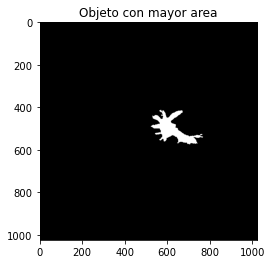

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


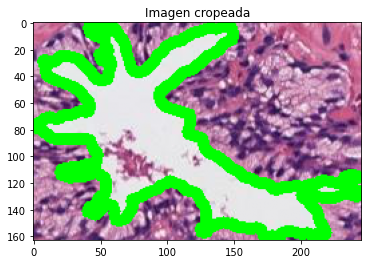

In [9]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
# Visualizar el lumen cropeado.
from tabulate import tabulate
import math

#sabemos el total de lumens
lab, num = label(filled_bordes, return_num=True)


print('número de objetos: ', num)
v,c = np.unique(lab, return_counts=True)
print('posibles valores de intensidad: ', v)


#identificamos el numero de bordes en conjunto con el anterior 
new_lab, new_num = label(filled_bordes, return_num=True)

# Extraemos las característicias geométricas
headers = v
A = ['area']

for i in range(1,new_num+1):
    objeto = new_lab == i
    prop = regionprops(objeto.astype(np.uint8))
    
    A.append(np.round(prop[0].area, 4))
    

my_data = [tuple(A)]

print(tabulate(my_data, headers=headers))
#con esto identificamos el lumen que tiene mayor area
A=list(A[1:])
area_max=max(A)
index_max=A.index(area_max)
print(index_max+1)
#identificamos en la imagen de cual se trata
objeto = lab == index_max+1
objeto = objeto.astype('uint8')
plt.imshow(objeto, cmap='gray')
plt.title('Objeto con mayor area')
plt.show()
#cropeamos la imagen identificando el de mayor area
prop = regionprops(objeto)
bbox = prop[0].bbox
start_point = (bbox[1], bbox[0])
end_point = (bbox[3], bbox[2])
window = cv2.rectangle(imagen.copy(), start_point, end_point, (0, 255, 0), 8)
                     
#con esto conseguimos identificar con exactitud cual tiene mayor area.
crop=imagen[bbox[0]:bbox[2],bbox[1]:bbox[3]]
plt.imshow(crop,cmap='gray')
plt.title('Imagen cropeada')
plt.show()

#### 8) Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [10]:
# Calcular las siguientes características del crop del lumen de mayor área, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Diámetro Feret
# 8) Longitud del eje mayor
# 9) Longitud del eje menor
# 10) Orientación
# 11) Perímetro
# 12) Solidez
# 13) Compacidad

objeto = lab == index_max+1
objeto = objeto.astype('uint8')
prop = regionprops(objeto)
bbox = prop[0].bbox

area=np.round(prop[0].area, 4)
boundingbox=np.round(prop[0].bbox_area, 4)
convex_area=np.round(prop[0].convex_area, 4)
eccentricity=np.round(prop[0].eccentricity, 4)
equiv_diameter=np.round(prop[0].equivalent_diameter, 4)
extent=np.round(prop[0].extent, 4)
major_axis=np.round(prop[0].major_axis_length, 4)
minor_axis=np.round(prop[0].minor_axis_length, 4)
orientation=np.round(prop[0].orientation, 4)
perimeter=np.round(prop[0].perimeter, 4)
solidity=np.round(prop[0].solidity, 4)
compactness=np.round(4*math.pi*prop[0].area/prop[0].perimeter**2, 4)
rectangularity=np.round(prop[0].area/prop[0].bbox_area, 4)
Diametro_Feret=np.round(prop[0].perimeter/math.pi,4)


print("Caracteristicas del lumen con mayor area:\n"+ "area:",area,"\nbouning box:",boundingbox,"\nconvex_area:",convex_area,"\neccentricity:",eccentricity,"\nequiv_diameter:",equiv_diameter,
     "\nextent:",extent,"\nmajor_axis:",major_axis,"\nminor_axis:",minor_axis,"\norientation:",orientation,"\nperimeter:",perimeter,"\nsolidity:",solidity,"\ncompactness:",compactness,"\nrectangularity:",rectangularity,"\nDiametro_Feret",Diametro_Feret)

Caracteristicas del lumen con mayor area:
area: 14078 
bouning box: 40098 
convex_area: 29281 
eccentricity: 0.8477 
equiv_diameter: 133.883 
extent: 0.3511 
major_axis: 238.5821 
minor_axis: 126.5581 
orientation: 1.0054 
perimeter: 1242.0113 
solidity: 0.4808 
compactness: 0.1147 
rectangularity: 0.3511 
Diametro_Feret 395.3445
